In [1]:
%matplotlib notebook
import amfe
import matplotlib.pyplot as plt
import numpy as np
from pyfeti import utils, linalg, feti_solver
from pyfeti import feti_solver as fetisolver
import pandas as pd
from scipy import sparse
import scipy

#mshfile = r'..\mesh\one_third_ring.inp'
mshfile = r'..\mesh\one_third_ring.msh'
m = amfe.Mesh()

try:
    m.import_inp(mshfile)
except:
    m.import_msh(mshfile)


Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

*************************************************************

Loading Abaqus-mesh from ..\mesh\one_third_ring.msh


In [2]:
m1 = m
m2 = m.rot_z(120)
m3 = m.rot_z(240)

<IPython.core.display.Javascript object>


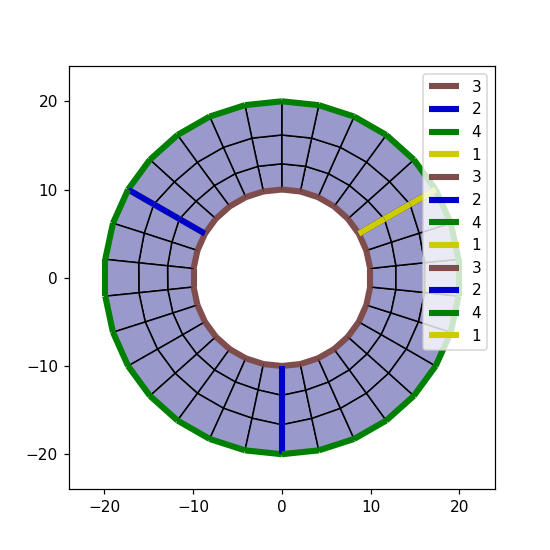

(-24.0, 24.0)

In [3]:
fig, ax1 = plt.subplots(figsize=(5,5))
amfe.plot2Dmesh(m1,ax=ax1)
amfe.plot2Dmesh(m2,ax=ax1)
amfe.plot2Dmesh(m3,ax=ax1)
lim = 1.2*np.array([-20,20])
ax1.set_xlim(lim)
ax1.set_ylim(lim)

In [4]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(5,my_material)

my_comp2 = amfe.MechanicalSystem()
my_comp2.set_mesh_obj(m2)
my_comp2.set_domain(5,my_material)

my_comp3 = amfe.MechanicalSystem()
my_comp3.set_mesh_obj(m3)
my_comp3.set_domain(5,my_material)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 30 elements and 88 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 30 elements and 88 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 30 elements and 88 dofs.
Time taken for preallocation: 0.00 seconds.


In [5]:
# assembling sector matrices
K_1, f = my_comp.assembly_class.assemble_k_and_f()
M_1 = my_comp.assembly_class.assemble_m()

K_2, f = my_comp2.assembly_class.assemble_k_and_f()
M_2 = my_comp2.assembly_class.assemble_m()

K_3, f = my_comp3.assembly_class.assemble_k_and_f()
M_3 = my_comp3.assembly_class.assemble_m()

# preparing cyclic case
# defining sector angle
K = K_1
M = M_1
theta = 2.0*np.pi/3.0 #
ndofs=K.shape[0]
R1 = linalg.create_voigt_rotation_matrix(ndofs,theta,dim=2)
R2 = linalg.create_voigt_rotation_matrix(ndofs,2*theta,dim=2)

apply_rotation = lambda A,R : R.T.dot(A.dot(R))

# sector 1
K1 = K_1
M1 = M_1

# sector 2
K2 = apply_rotation(K,R1)
M2 = apply_rotation(M,R1)

# sector 3
K3 = apply_rotation(K,R2)
M3 = apply_rotation(M,R2)

# test matrices
print(np.allclose(K_1.A, K1.A))
print(np.allclose(K_2.A, K2.A))
print(np.allclose(K_3.A, K3.A))


print(np.allclose(M_1.A, M1.A))
print(np.allclose(M_2.A, M2.A))
print(np.allclose(M_3.A, M3.A))

True
True
True
True
True
True


In [6]:
id_matrix = my_comp.assembly_class.id_matrix
id_map_df = utils.dict2dfmap(id_matrix )

group_dict = utils.OrderedDict()

m.split_in_groups()
node_set_1 = m.groups[1].global_node_list # Left
node_set_2 = m.groups[2].global_node_list # Right
node_set_3 = m.groups[3].global_node_list # Dirichlet

# Defining a new node order in the right side to match with the left side
new_node_set_right = linalg.find_cyclic_node_pairs(node_set_1,node_set_2,theta,m.nodes)

manager_obj = utils. DofManager(id_map_df)

group_dict = utils.OrderedDict()
group_dict['Dirichlet'] = utils.OrderedSet(manager_obj.get(node_set_3,'xy'))
group_dict['Left'] = utils.OrderedSet(manager_obj.get(node_set_1,'xy'))
group_dict['Right'] = utils.OrderedSet(manager_obj.get(new_node_set_right,'xy'))

s = utils.SelectionOperator(group_dict, id_map_df)


In [7]:
K1d, sred = s.assemble_matrix(K1.toarray(),['Left','Right','internal'],True)
K2d = s.assemble_matrix(K2.toarray(),['Left','Right','internal'],False)
K3d = s.assemble_matrix(K3.toarray(),['Left','Right','internal'],False)

M1d, sred = s.assemble_matrix(M1.toarray(),['Left','Right','internal'],True)
M2d = s.assemble_matrix(M2.toarray(),['Left','Right','internal'],False)
M3d = s.assemble_matrix(M3.toarray(),['Left','Right','internal'],False)

B1 = sred.build_B('Left')
B2 = sred.build_B('Right')
n_sectors = 3
K_list = [K1d,K2d,K3d]
M_list = [M1d,M2d,M3d]
K_dict = {}
M_dict = {}
B_dict = {}
f_dict = {}
for i in range(1,n_sectors+1):
    K_dict[i] = K_list[i-1]
    M_dict[i] = M_list[i-1]
    iplus = i + 1
    iminus = i - 1
    if iminus==0:
        iminus = 3
    if iplus==4:
        iplus = 1
        
    B_dict[i] = {(i,iplus):B1,(i,iminus):B2}
    f_dict[i] = np.zeros(K_list[i-1].shape[0])


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Solving Projected Eigenvalue Problem
------------------------------------------------------


$$ P^T K P u = \omega^2 P^T  M P u $$


In [8]:
feticase = fetisolver.FETIManager(K_dict,B_dict,f_dict)
feticase2 = fetisolver.FETIManager(M_dict,B_dict,f_dict)
K_global, f_global = feticase.assemble_global_K_and_f()
M_global, f_global = feticase2.assemble_global_K_and_f()
B = feticase.assemble_global_B().tocsc()

K_global, M_global = K_global.tocsc(), M_global.tocsc()

BBT = B.dot(B.T)
BBT_inv = sparse.linalg.inv(BBT)
#P = sparse.eye(K_global.shape[0]) - B.T.dot(BBT_inv.dot(B))
P = sparse.eye(K_global.shape[0]) - 0.5*B.T.dot(B)

In [9]:
Kp = P.T.dot(K_global.dot(P))
Mp = P.T.dot(M_global.dot(P))


In [10]:
error = abs(K_global - Kp)

In [11]:
error.max()

117220036501.80759

In [12]:
w2, vec = scipy.linalg.eig(Kp.toarray(),Mp.toarray())

In [13]:
np.sort(np.sqrt(w2.real))/(2.0*np.pi)

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([  51.3570865 ,   67.73461818,   67.73461818,   99.04606709,
         99.04606709,  124.71396956,  124.85619393,  138.72227441,
        140.05945607,  140.28401421,  140.28401421,  144.59051013,
        144.59051013,  145.90764598,  145.90764598,  167.58810384,
        167.58810384,  168.76001492,  168.80721459,  195.46907639,
        195.73050604,  207.96431447,  207.96431447,  228.22570978,
        228.22570978,  253.2765484 ,  253.2765484 ,  260.08588364,
        264.80995874,  264.80995874,  265.30488073,  265.30488073,
        269.09368046,  269.09368046,  293.49612949,  293.49612949,
        301.25365348,  301.96533302,  304.4422005 ,  304.90951873,
        328.70077749,  329.16146725,  346.75863543,  346.75863543,
        352.43412961,  352.43412961,  372.37256035,  372.37256035,
        389.50093823,  389.50093823,  405.56142483,  405.56142483,
        421.93856746,  421.93856746,  429.97229059,  430.35115792,
        438.65187781,  440.42123845,  440.42123845,  441.77899

In [14]:
v = np.random.rand(Kp.shape[0])
v/=np.linalg.norm(v)
vp = P.dot(v)

In [15]:
B.dot(vp)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

<IPython.core.display.Javascript object>


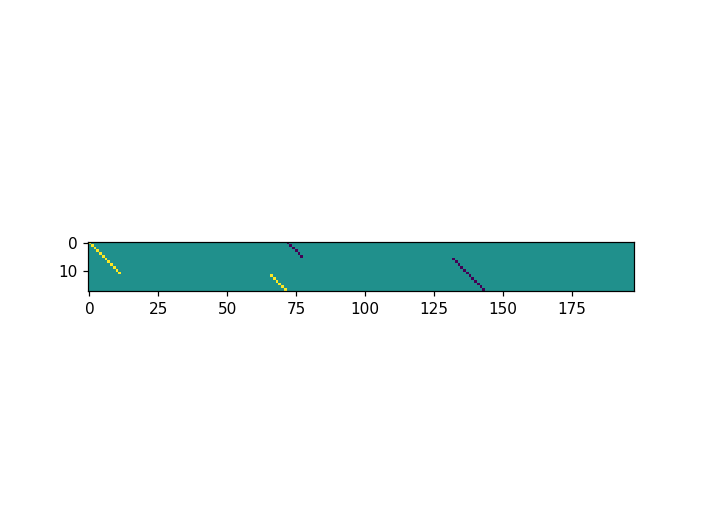

In [16]:
plt.figure()
plt.imshow(B.toarray())
plt.show()

In [17]:
lo_obj = linalg.ProjLinearSys(K_global,M_global,P)
Dp_new = lo_obj.getLinearOperator()
w2new, v2new = sparse.linalg.eigs(Dp_new, k=20)
new_id = np.argsort(w2new)[::-1]
w2new = w2new[new_id]
v2new = v2new[:,new_id]
eigenvalues = 1.0/(w2new.real)
omega = np.sqrt(eigenvalues)
frequency = omega/(2.0*np.pi)

In [18]:
frequency

array([ 51.3570865 ,  67.73461818,  67.73461818,  99.04606709,
        99.04606709, 124.71396956, 124.85619393, 140.05945607,
       140.28401421, 140.28401421, 144.59051013, 144.59051014,
       145.90764598, 145.90764598, 167.58810384, 167.58810384,
       168.76001492, 168.80721458, 195.46907639, 195.73050604])

In [25]:
B12 = B_dict[1][1,2]

In [26]:
B21 = B_dict[2][2,1]

In [29]:
print((B12.T.dot(B21)).max())
print((B12.T.dot(B21)).min())

1
0


Solving Dual Eigenvalue Problem
------------------------------------------------------


$$ 
\begin{bmatrix}
K & B^T \\
B & 0  \\
\end{bmatrix}
\begin{bmatrix}
u \\
\lambda  
\end{bmatrix}
 = \omega^2 
 \begin{bmatrix}
M & 0 \\
0 & 0  \\
\end{bmatrix}
\begin{bmatrix}
u \\
\lambda  
\end{bmatrix}
 $$


In [90]:
nc, ndofs = B.shape
zero_vec = np.zeros(nc)

vr =  np.random.rand(ndofs)
v = P.dot(M_global.dot(P.dot(vr)))

vdual = np.concatenate((v,zero_vec))
A = scipy.sparse.bmat([[K_global,B.T],[B,None]]).tocsc()

# solving dual problem
xdual = sparse.linalg.spsolve(A,vdual)
udual = xdual[:ndofs]

# solving projected problem
uproj = sparse.linalg.cg(Kp,v,tol=1e-10)[0]

# checking the error between solutions
print(np.allclose(uproj,udual))

True


<IPython.core.display.Javascript object>


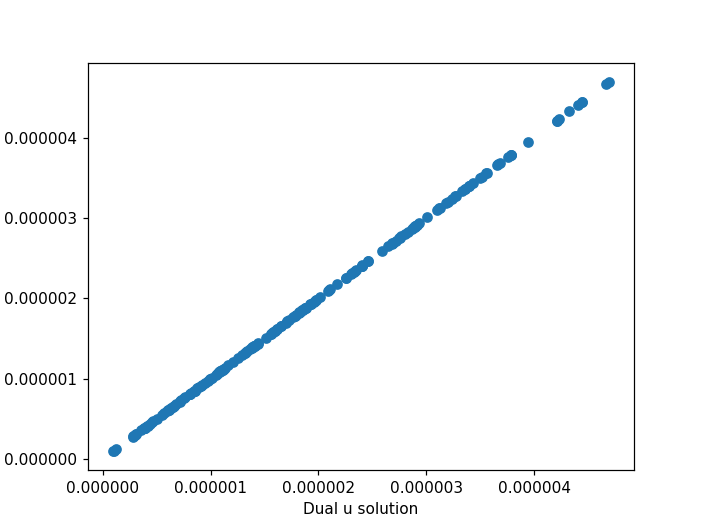

Text(0,0.5,'Projected u solution')

In [91]:
plt.figure()
plt.plot(udual,uproj,'o')
plt.xlabel('Dual u solution')
plt.ylabel('Projected u solution')

In [92]:
m.el_df

,idx_gmsh,el_type,no_of_tags,phys_group,geom_entity,5,6,7,8
0,1,straight_line,2,3,1,0,4,NaN,NaN
1,2,straight_line,2,3,1,4,5,NaN,NaN
2,3,straight_line,2,3,1,5,6,NaN,NaN
3,4,straight_line,2,3,1,6,7,NaN,NaN
4,5,straight_line,2,3,1,7,8,NaN,NaN
5,6,straight_line,2,3,1,8,9,NaN,NaN
6,7,straight_line,2,3,1,9,10,NaN,NaN
7,8,straight_line,2,3,1,10,11,NaN,NaN
8,9,straight_line,2,3,1,11,12,NaN,NaN
9,10,straight_line,2,3,1,12,1,NaN,NaN


In [93]:
Krd

NameError: name 'Krd' is not defined

In [94]:
v2new

array([[-0.06408678+0.01565528j, -0.06722807-0.02688153j,
         0.03575436+0.0182235j , ..., -0.07407725-0.06337021j,
         0.06911671-0.12596407j, -0.01799707-0.00725316j],
       [-0.11102468+0.02712139j, -0.08462677-0.07952517j,
         0.10802583+0.00378914j, ..., -0.12437316-0.10639641j,
        -0.0399086 +0.07273276j, -0.03261631-0.013145j  ],
       [-0.02906647+0.00710043j, -0.02958454-0.01449887j,
         0.01941608+0.00690057j, ..., -0.00286578-0.00245156j,
         0.02649991-0.04829566j,  0.02708411+0.01091541j],
       ...,
       [ 0.05015547-0.0122521j , -0.00568252-0.04863186j,
         0.0669687 -0.01789236j, ...,  0.00781093+0.00668195j,
        -0.02515991+0.04585352j,  0.00220125+0.00088714j],
       [-0.0298051 +0.00728086j, -0.01468973+0.02824458j,
        -0.03924885+0.01828343j, ...,  0.02102596+0.01798689j,
        -0.01093728+0.01993302j,  0.12710802+0.05122695j],
       [ 0.09134434-0.02231382j, -0.01157066-0.08780018j,
         0.12087976-0.03172767